In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy.stats import jarque_bera

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None) # show full width of showing cols
pd.set_option("expand_frame_repr", False) # print cols side by side as it's supposed to be
pd.options.display.max_seq_items = 200000

In [4]:
DF = pd.read_excel('data/data8.xls')

In [5]:
# Percent of rented properties
DF['pctrnths'] = DF['rnthsg'] / DF['tothsg'] * 100

# Logarithm of percent of rented properties
DF['lpctrnths'] = np.log(DF['pctrnths'])

# Squared average income
DF['avgincsq'] = DF['avginc'] ** 2

In [6]:
DF80 = DF[DF['year'] == 80]
DF90 = DF[DF['year'] == 90]

In [7]:
# Calculate the diff for logarithm of change in percent of rented properties (lpctrnths)
pivot_df = DF.pivot(index='city', columns='year', values='lpctrnths')
pivot_df['clpctrnths'] = pivot_df[90] - pivot_df[80]
result_df = pivot_df.reset_index()

# Add new column 'clpctrnths' to DF90
DF90 = pd.merge(DF90,result_df,on='city',how='left')

## Linear regression for change parameters (change in log average income, change in log population, change in log percent students, change in log percent rented houses)

In [8]:
# Linear regression for change parameters
X_change = DF90[['clavginc', 'clpop', 'cpctstu', 'clpctrnths']]
y_change = DF90['clrent']

model_change = sm.OLS(y_change.astype(float), X_change.astype(float)).fit()
y_change_pred = X_change@model_change.params.values

print(model_change.summary())

                                 OLS Regression Results                                
Dep. Variable:                 clrent   R-squared (uncentered):                   0.934
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              211.1
Date:                Mon, 22 Jan 2024   Prob (F-statistic):                    1.31e-34
Time:                        14:43:02   Log-Likelihood:                          32.020
No. Observations:                  64   AIC:                                     -56.04
Df Residuals:                      60   BIC:                                     -47.41
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

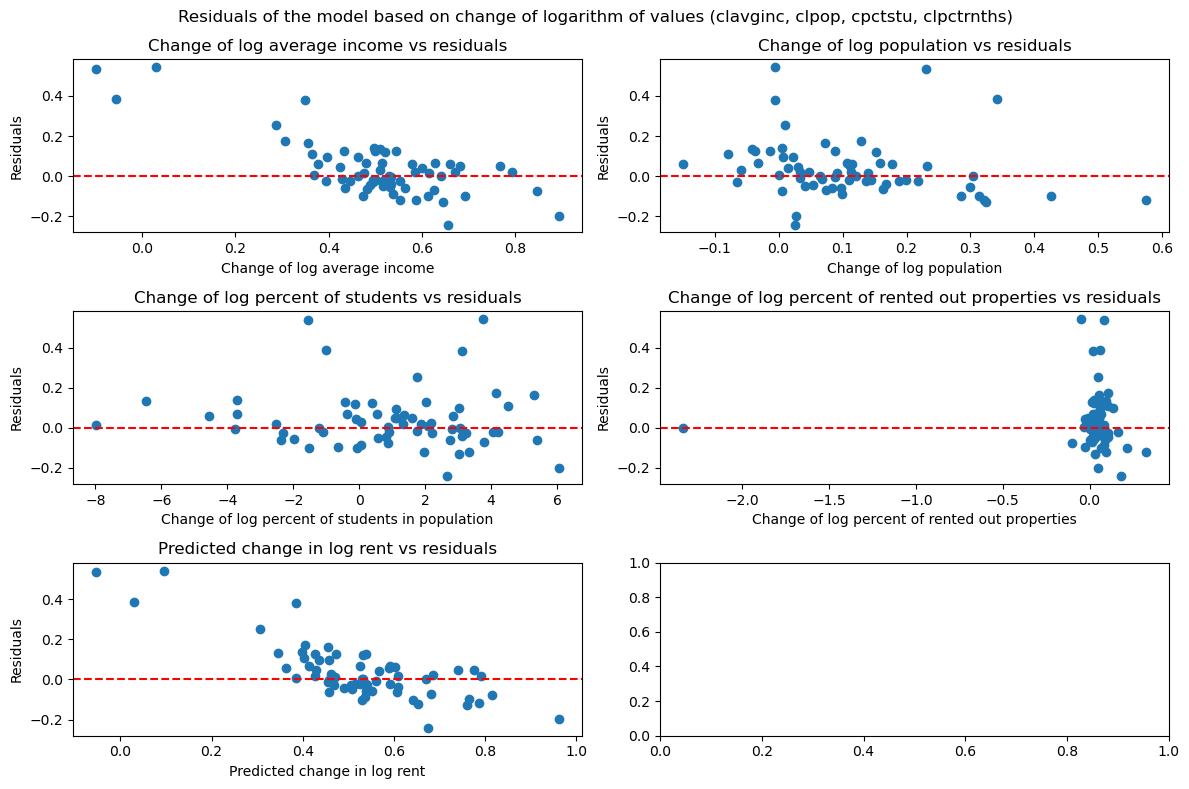

In [9]:
def populate_subplot(ax, x, resid, title, xlabel):
    ax.scatter(x, resid)
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Residuals")


# Plot residuals in relation to different params and to predicted values
_, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 8))

populate_subplot(ax1, X_change[['clavginc']], model_change.resid, 'Change of log average income vs residuals',
                 xlabel="Change of log average income")
populate_subplot(ax2, X_change[['clpop']], model_change.resid, 'Change of log population vs residuals',
                 xlabel="Change of log population")
populate_subplot(ax3, X_change[['cpctstu']], model_change.resid, 'Change of log percent of students vs residuals',
                 xlabel="Change of log percent of students in population")
populate_subplot(ax4, X_change[['clpctrnths']], model_change.resid,
                 'Change of log percent of rented out properties vs residuals',
                 xlabel="Change of log percent of rented out properties")
populate_subplot(ax5, y_change_pred, model_change.resid, 'Predicted change in log rent vs residuals',
                 xlabel="Predicted change in log rent")

plt.suptitle('Residuals of the model based on change of logarithm of values (clavginc, clpop, cpctstu, clpctrnths)')
plt.tight_layout()
plt.show()

In [10]:
jb_test = jarque_bera(model_change.resid)
jb_test

SignificanceResult(statistic=62.424008537716, pvalue=2.784830564861406e-14)

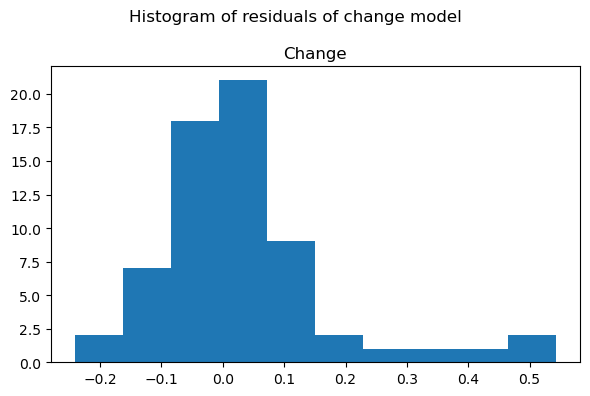

In [11]:
_, (ax) = plt.subplots(1, 1, figsize=(6, 4))

ax.hist(model_change.resid)
ax.set_title('Change')

plt.suptitle('Histogram of residuals of change model')
plt.tight_layout()
plt.show()

In [12]:
print("Mean of residuals for change linear model: ", np.average(model_change.resid))
print("Jaque-Bera test for residuals of change linear model: ", jarque_bera(model_change.resid))

Mean of residuals for change linear model:  0.03608254557216441
Jaque-Bera test for residuals of change linear model:  SignificanceResult(statistic=62.424008537716, pvalue=2.784830564861406e-14)
